In [1]:
!nvidia-smi

Mon May 20 07:30:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


In [3]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.18 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5597.6/8062.4 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [4]:
%cd {HOME}
!git clone -b rectified https://github.com/0001ashish/ByteTrack
# !git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [5]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [6]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [7]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
# from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [8]:
from typing import Dict

import cv2
import numpy as np

from supervision.draw.color import Color
from supervision.geometry.dataclasses import Point, Rect, Vector
from supervision.tools.detections import Detections


class LineCounter:
    def __init__(self, start: Point, end: Point):
        """
        Initialize a LineCounter object.

        :param start: Point : The starting point of the line.
        :param end: Point : The ending point of the line.
        """
        self.vector = Vector(start=start, end=end)
        self.tracker_state: Dict[str, bool] = {}
        self.in_count: int = 0
        self.out_count: int = 0

    def update(self, detections: Detections):
        """
        Update the in_count and out_count for the detections that cross the line.

        :param detections: Detections : The detections for which to update the counts.
        """
        for xyxy, confidence, class_id, tracker_id in detections:
            # handle detections with no tracker_id
            if tracker_id is None:
                continue

            # we check if all four anchors of bbox are on the same side of vector
            x1, y1, x2, y2 = xyxy

            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2

            x1_new = center_x - 20
            y1_new = center_y - 20
            x2_new = center_x + 20
            y2_new = center_y + 20

            anchors = [
                Point(x=x1_new, y=y1_new),
                Point(x=x1_new, y=y2_new),
                Point(x=x2_new, y=y1_new),
                Point(x=x2_new, y=y2_new),
            ]

            # anchors = [
            #     Point(x=x1, y=y1),
            #     Point(x=x1, y=y2),
            #     Point(x=x2, y=y1),
            #     Point(x=x2, y=y2),
            # ]

            # print("Point", (center_x, center_y))

            triggers = [self.vector.is_in(point=anchor) for anchor in anchors]

            # detection is partially in and partially out
            if len(set(triggers)) == 2:
                continue

            tracker_state = triggers[0]
            # handle new detection
            if tracker_id not in self.tracker_state:
                self.tracker_state[tracker_id] = tracker_state
                continue

            # handle detection on the same side of the line
            if self.tracker_state.get(tracker_id) == tracker_state:
                continue

            self.tracker_state[tracker_id] = tracker_state
            if tracker_state:
                self.in_count += 1
            else:
                self.out_count += 1


class LineCounterAnnotator:
    def __init__(
        self,
        thickness: float = 2,
        color: Color = Color.white(),
        text_thickness: float = 2,
        text_color: Color = Color.black(),
        text_scale: float = 0.5,
        text_offset: float = 1.5,
        text_padding: int = 10,
    ):
        """
        Initialize the LineCounterAnnotator object with default values.

        :param thickness: float : The thickness of the line that will be drawn.
        :param color: Color : The color of the line that will be drawn.
        :param text_thickness: float : The thickness of the text that will be drawn.
        :param text_color: Color : The color of the text that will be drawn.
        :param text_scale: float : The scale of the text that will be drawn.
        :param text_offset: float : The offset of the text that will be drawn.
        :param text_padding: int : The padding of the text that will be drawn.
        """
        self.thickness: float = thickness
        self.color: Color = color
        self.text_thickness: float = text_thickness
        self.text_color: Color = text_color
        self.text_scale: float = text_scale
        self.text_offset: float = text_offset
        self.text_padding: int = text_padding

    def annotate(self, frame: np.ndarray, line_counter: LineCounter) -> np.ndarray:
        """
        Draws the line on the frame using the line_counter provided.

        :param frame: np.ndarray : The image on which the line will be drawn
        :param line_counter: LineCounter : The line counter that will be used to draw the line
        :return: np.ndarray : The image with the line drawn on it
        """
        cv2.line(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            line_counter.vector.end.as_xy_int_tuple(),
            self.color.as_bgr(),
            self.thickness,
            lineType=cv2.LINE_AA,
            shift=0,
        )
        cv2.circle(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )
        cv2.circle(
            frame,
            line_counter.vector.end.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )

        in_text = f"in: {line_counter.out_count}"
        out_text = f"out: {line_counter.in_count}"

        (in_text_width, in_text_height), _ = cv2.getTextSize(
            in_text, cv2.FONT_HERSHEY_SIMPLEX, self.text_scale, self.text_thickness
        )
        (out_text_width, out_text_height), _ = cv2.getTextSize(
            out_text, cv2.FONT_HERSHEY_SIMPLEX, self.text_scale, self.text_thickness
        )

        in_text_x = int(
            (line_counter.vector.end.x + line_counter.vector.start.x - in_text_width)
            / 2
        )
        in_text_y = int(
            (line_counter.vector.end.y + line_counter.vector.start.y + in_text_height)
            / 2
            - self.text_offset * in_text_height
        )

        out_text_x = int(
            (line_counter.vector.end.x + line_counter.vector.start.x - out_text_width)
            / 2
        )
        out_text_y = int(
            (line_counter.vector.end.y + line_counter.vector.start.y + out_text_height)
            / 2
            + self.text_offset * out_text_height
        )

        in_text_background_rect = Rect(
            x=in_text_x,
            y=in_text_y - in_text_height,
            width=in_text_width,
            height=in_text_height,
        ).pad(padding=self.text_padding)
        out_text_background_rect = Rect(
            x=out_text_x,
            y=out_text_y - out_text_height,
            width=out_text_width,
            height=out_text_height,
        ).pad(padding=self.text_padding)

        cv2.rectangle(
            frame,
            in_text_background_rect.top_left.as_xy_int_tuple(),
            in_text_background_rect.bottom_right.as_xy_int_tuple(),
            self.color.as_bgr(),
            -1,
        )
        cv2.rectangle(
            frame,
            out_text_background_rect.top_left.as_xy_int_tuple(),
            out_text_background_rect.bottom_right.as_xy_int_tuple(),
            self.color.as_bgr(),
            -1,
        )

        cv2.putText(
            frame,
            in_text,
            (in_text_x, in_text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            self.text_color.as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )
        cv2.putText(
            frame,
            out_text,
            (out_text_x, out_text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            self.text_color.as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )


In [9]:
!pip show supervision

Name: supervision
Version: 0.1.0
Summary: A set of easy-to-use utils that will come in handy in any Computer Vision project
Home-page: https://github.com/roboflow/supervision
Author: Piotr Skalski
Author-email: piotr.skalski92@gmail.com
License: MIT
Location: /opt/conda/lib/python3.10/site-packages
Requires: numpy, opencv-python
Required-by: 


## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [10]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [11]:
# settings
# !gdown --id 1EmOr5x6WDIIcOut0_ae9lZXd2OajneB7   #model m_old
# !gdown --id 1XnK54yYqjvqZvrhcDYwQweeCLijnLdio  #model x_old

# !gdown --id 1cvinl/models-finl/bestx_old.pt1SV2MRF4wjipWj1z4_bn60X4rC3k8k   #model x_new
MODEL = "/kaggle/input/vending-machine-dataset/best.pt"

In [12]:
%cd {HOME}/ByteTrack

from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

/kaggle/working/ByteTrack
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


## Predict and annotate single frame

In [13]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

CLASS_ID = [0] # hand_wiht_object

In [14]:
VIDEO_NAME = "1 (100).mov"


# SOURCE_VIDEO_PATH = "../test_input_videos/10_2024.04.02-09.08.24.mov"
SOURCE_VIDEO_PATH = f"/kaggle/input/vending-machine-dataset/videos_sort/videos_sort/{VIDEO_NAME}"

# SOURCE_VIDEO_PATH = "/content/1_2024.03.04-22.19.55.mov"
# SOURCE_VIDEO_PATH ="/content/4_2024.03.01-18.06.00.mov"
# SOURCE_VIDEO_PATH = "/content/13_2024.03.25-12.02.14.mov"
# SOURCE_VIDEO_PATH = "/content/34_2024.03.25-11.45.46.mov"
# SOURCE_VIDEO_PATH = "/content/119_2023.03.27-14.06.34.mov"

In [15]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)

my_xyxy = results[0].boxes.xyxy.cpu().numpy()

my_xyxy_np = np.array(my_xyxy)
xyxy_new = my_xyxy_np.copy()  # Make a copy to avoid modifying original data

for i, box in enumerate(my_xyxy):

    x, y, x_a, y_a = box

    center_x = (x + x_a) / 2
    center_y = (y + y_a) / 2

    # x1_new = center_x - 25
    # y1_new = center_y - 25
    # x2_new = center_x + 25
    # y2_new = center_y + 25

    x1_new = center_x - 50
    y1_new = center_y - 50
    x2_new = center_x + 50
    y2_new = center_y + 50

    xyxy_new[i] = [x1_new, y1_new, x2_new, y2_new]

detections = Detections(
    # xyxy=xyxy_new,
    xyxy=my_xyxy,
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

# %matplotlib inline
# show_frame_in_notebook(frame, (16, 16))


0: 256x640 (no detections), 105.6ms
Speed: 11.5ms preprocess, 105.6ms inference, 67.3ms postprocess per image at shape (1, 3, 256, 640)


## Predict and annotate whole video

In [16]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=960, height=360, fps=87, total_frames=2431)

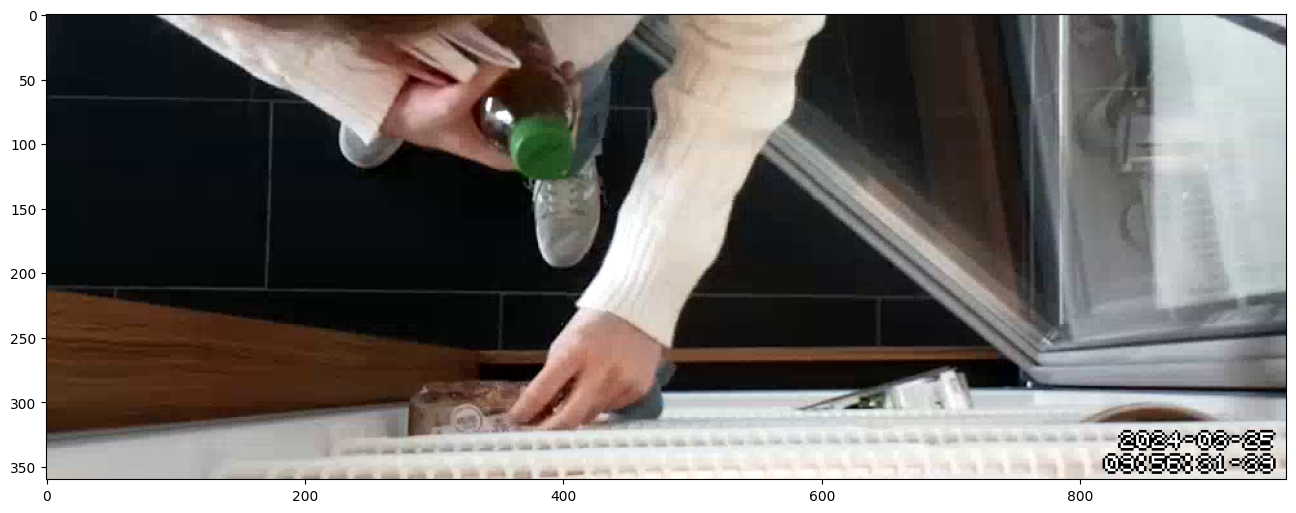

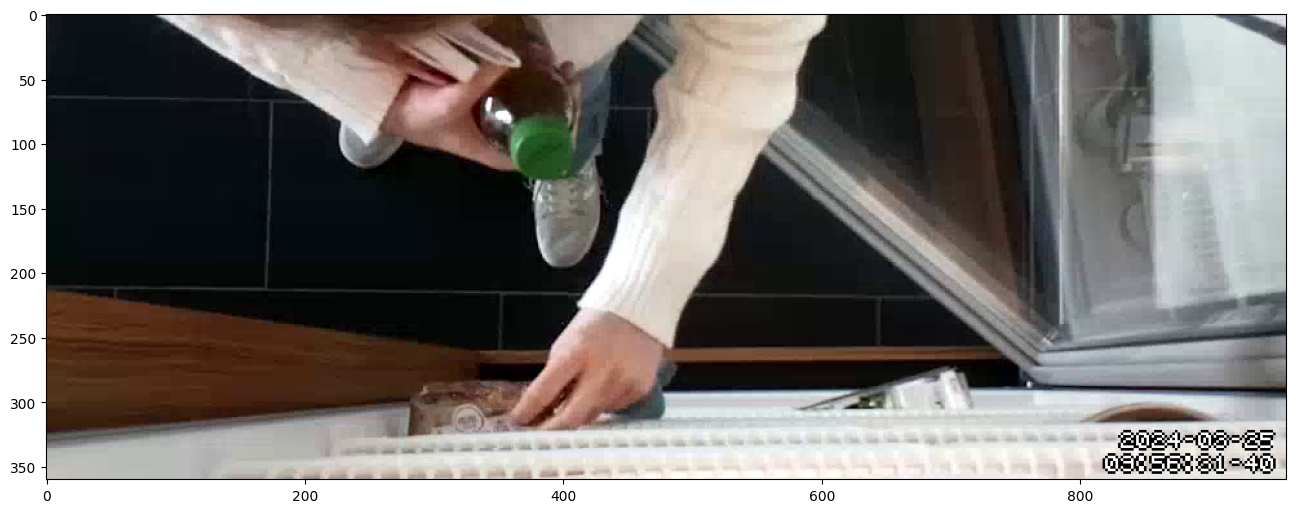

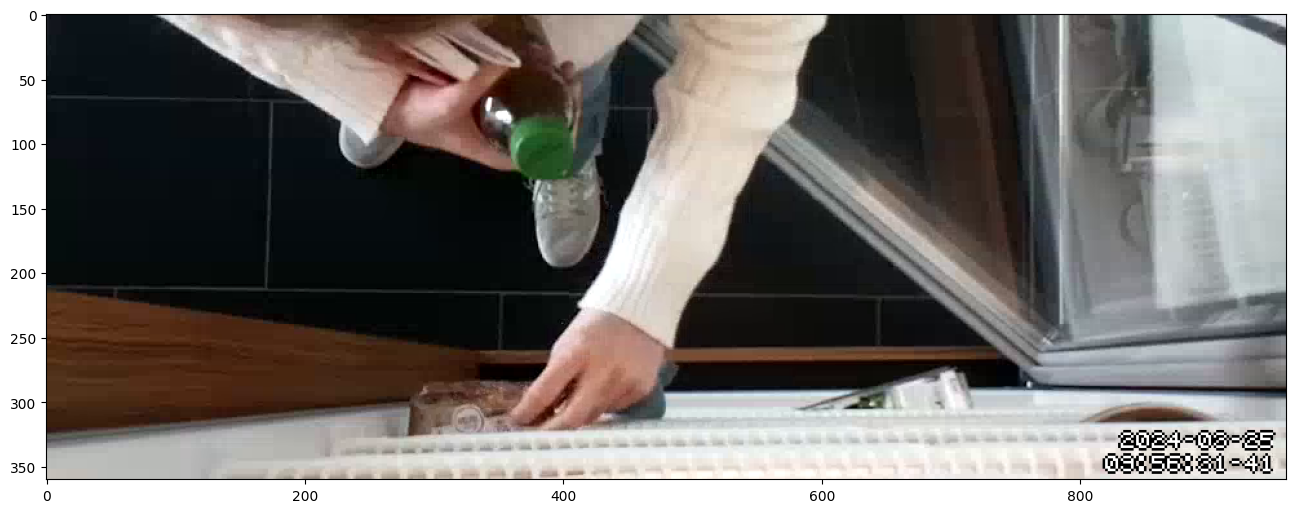

In [17]:
# Check diffirent frames to chose the position of line
def get_frame_at_position(generator, start_position, end_position):
    
    #Retrieve a specific frame from a video generator.
    iterator = iter(generator)
    # Skip frames until reaching the desired position
    for _ in range(start_position - 1):
        next(iterator)
    # Get the frame at the specified position
    for _ in range(end_position):
        frame = next(iterator)
        show_frame_in_notebook(frame, (16, 16))
    return frame

# Usage example: acquire the 200th video frame to 3 consective
frame_p = get_frame_at_position(generator, 350, 3)


In [18]:
# # settings 68  xx
# LINE_START = Point(0, 275)
# LINE_END = Point(960, 275)

# settings 66
# LINE_START = Point(0, 240)
# LINE_END = Point(960, 240)

# # settings 59
LINE_START = Point(0, 177)  # 150
LINE_END = Point(960, 177)  # 150

# # settings 10
# LINE_START = Point(0, 210)
# LINE_END = Point(960, 210)

# settings 119
# LINE_START = Point(0, 205)
# LINE_END = Point(960, 205)

# # settings 34
# LINE_START = Point(0, 160)
# LINE_END = Point(960, 160)

# # settings 13
# LINE_START = Point(0, 220)
# LINE_END = Point(960, 220)

# # # settings 1
# LINE_START = Point(0, 240)
# LINE_END = Point(960, 240)

# # # settings 4
# LINE_START = Point(0, 270)
# LINE_END = Point(960, 270)

TARGET_VIDEO_PATH = f"/kaggle/working/{VIDEO_NAME}"

In [19]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=960, height=360, fps=87, total_frames=2431)

In [20]:
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale= 1)
line_annotator = LineCounterAnnotator(thickness=1, text_thickness=1, text_scale = 1)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)

        my_xyxy = results[0].boxes.xyxy.cpu().numpy()

        my_xyxy_np = np.array(my_xyxy)
        xyxy_new = my_xyxy_np.copy()  # Make a copy to avoid modifying original data

        for i, box in enumerate(my_xyxy):

            x1, y1, x2, y2 = box

            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2

            x1_new = center_x - 30
            y1_new = center_y - 30
            x2_new = center_x + 30
            y2_new = center_y + 30

            xyxy_new[i] = [x1_new, y1_new, x2_new, y2_new]

        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            # xyxy = xyxy_new,
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )

        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]

        # updating line counter
        line_counter.update(detections=detections)

        print(line_counter.in_count)

        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/2431 [00:00<?, ?it/s]


0: 256x640 (no detections), 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)
0

0: 256x640 (no detections), 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)
0

0: 256x640 (no detections), 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)
0

0: 256x640 (no detections), 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)
0

0: 256x640 (no detections), 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)
0

0: 256x640 (no detections), 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)
0

0: 256x640 (no detections), 10.7ms
Speed: 1.8ms preprocess, 10.7ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)
0

0: 256x640 (no detections), 10.7ms
Speed: 1.2ms prepro

In [21]:

"""

# This module take an input folder, take videos one by one, count products and save into another folder
import os
import shutil

# Input and output folder paths
input_folder = '/kaggle/input/vending-machine-dataset/videos_sort/videos_sort'
output_folder = '/kaggle/working/processed'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate over each file in the input folder
for filename in os.listdir(input_folder):
    # Check if the file is a video file (you may need to adjust this condition based on your file extensions)
    if filename.endswith('.mov'):
        # Construct the full path to the input and output files
        input_file_path = os.path.join(input_folder, filename)
        output_file_path = os.path.join(output_folder, filename)
        
        
        SOURCE_VIDEO_PATH=input_file_path 
        # Process the video file (replace this with your processing code)
        # create BYTETracker instance
        byte_tracker = BYTETracker(BYTETrackerArgs())
        # create VideoInfo instance
        video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
        # create frame generator
        generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
        # create LineCounter instance
        line_counter = LineCounter(start=LINE_START, end=LINE_END)
        # create instance of BoxAnnotator and LineCounterAnnotator
        box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale= 1)
        line_annotator = LineCounterAnnotator(thickness=1, text_thickness=1, text_scale = 1)

        TARGET_VIDEO_PATH= output_file_path
        # open target video file
        with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
            # loop over video frames
            for frame in tqdm(generator, total=video_info.total_frames):
                # model prediction on single frame and conversion to supervision Detections
                results = model(frame)

                my_xyxy = results[0].boxes.xyxy.cpu().numpy()

                my_xyxy_np = np.array(my_xyxy)
                xyxy_new = my_xyxy_np.copy()  # Make a copy to avoid modifying original data

                for i, box in enumerate(my_xyxy):

                    x1, y1, x2, y2 = box

                    center_x = (x1 + x2) / 2
                    center_y = (y1 + y2) / 2

                    x1_new = center_x - 30
                    y1_new = center_y - 30
                    x2_new = center_x + 30
                    y2_new = center_y + 30

                    xyxy_new[i] = [x1_new, y1_new, x2_new, y2_new]

                detections = Detections(
                    xyxy=results[0].boxes.xyxy.cpu().numpy(),
                    # xyxy = xyxy_new,
                    confidence=results[0].boxes.conf.cpu().numpy(),
                    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
                )
                # filtering out detections with unwanted classes
                mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
                detections.filter(mask=mask, inplace=True)

                # tracking detections
                tracks = byte_tracker.update(
                    output_results=detections2boxes(detections=detections),
                    img_info=frame.shape,
                    img_size=frame.shape
                )

                tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
                detections.tracker_id = np.array(tracker_id)
                # filtering out detections without trackers
                mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
                detections.filter(mask=mask, inplace=True)
                # format custom labels
                labels = [
                    f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
                    for _, confidence, class_id, tracker_id
                    in detections
                ]

                # updating line counter
                line_counter.update(detections=detections)

                print(line_counter.in_count)

                # annotate and display frame
                frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
                line_annotator.annotate(frame=frame, line_counter=line_counter)
                sink.write_frame(frame)


        # For now, let's just copy the video file to the output folder
        #shutil.copy(input_file_path, output_file_path)
        
        print(f"Processed: {filename}")

print("All videos processed and saved to the output folder.")

"""

'\n\n# This module take an input folder, take videos one by one, count products and save into another folder\nimport os\nimport shutil\n\n# Input and output folder paths\ninput_folder = \'/kaggle/input/vending-machine-dataset/videos_sort/videos_sort\'\noutput_folder = \'/kaggle/working/processed\'\n\n# Create the output folder if it doesn\'t exist\nif not os.path.exists(output_folder):\n    os.makedirs(output_folder)\n\n# Iterate over each file in the input folder\nfor filename in os.listdir(input_folder):\n    # Check if the file is a video file (you may need to adjust this condition based on your file extensions)\n    if filename.endswith(\'.mov\'):\n        # Construct the full path to the input and output files\n        input_file_path = os.path.join(input_folder, filename)\n        output_file_path = os.path.join(output_folder, filename)\n        \n        \n        SOURCE_VIDEO_PATH=input_file_path \n        # Process the video file (replace this with your processing code)\n     